<a href="https://colab.research.google.com/github/CyantificCQ/Machine-Learning-experiments/blob/main/gan_monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
! pip install -q kaggle

In [32]:
from google.colab import files

In [33]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"drastadler","key":"fc4e3fac24392dd2fa558f53a2688362"}'}

In [34]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Mar  9 11:23 kaggle.json


In [35]:
!mkdir -p ~/.kaggle/

In [36]:
!cp kaggle.json ~/.kaggle

In [37]:
!pwd

/content


In [38]:
!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!kaggle competitions download -c gan-getting-started -p /content/drive/MyDrive/Monet_gan

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
!unzip /content/drive/MyDrive/Monet_gan/gan-getting-started.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

In [41]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras import Sequential 
import matplotlib.pyplot as plt 
import random

In [42]:
monet_tfrec = tf.io.gfile.glob(str("monet_tfrec/*.tfrec"))
photo_tfrec = tf.io.gfile.glob(str("photo_tfrec/*tfrec"))

print(f"Monet files {len(monet_tfrec)} \nPhoto files {len(photo_tfrec)}" )

Monet files 5 
Photo files 20


In [43]:
# # Preprocessing Tfrec format images

imsize = [256 , 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*imsize, 3])
    return image

def read_tfrec(data):
  data_set = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
  }

  data = tf.io.parse_single_example(data, data_set)
  image = decode_image(data["image"])
  return image

In [44]:
Buffer_size = 1000
batchs = 1

In [45]:
def load_data(filename, labeled=True, ordered=False):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.cache().map(read_tfrec, num_parallel_calls=tf.data.AUTOTUNE).shuffle(Buffer_size).batch(batchs)
  return dataset 

In [46]:
monet_data = load_data(monet_tfrec, labeled=True)
photo_data = load_data(photo_tfrec, labeled=True)

In [47]:
example_monet = next(iter(monet_data))
example_photo = next(iter(photo_data))

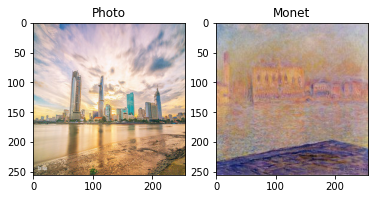

In [48]:
def plotting_images():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Photo')
    ax1.imshow(example_photo[0] * 0.5 + 0.5)
    ax2.set_title('Monet')
    ax2.imshow(example_monet[0] * 0.5 + 0.5)

plotting_images()

In [49]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [50]:
from tensorflow_examples.models.pix2pix import pix2pix

output_channels = 3

generator_a = pix2pix.unet_generator(output_channels, norm_type="instancenorm")
generator_b = pix2pix.unet_generator(output_channels, norm_type="instancenorm")
discriminator_a = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_b = pix2pix.discriminator(norm_type='instancenorm', target=False)

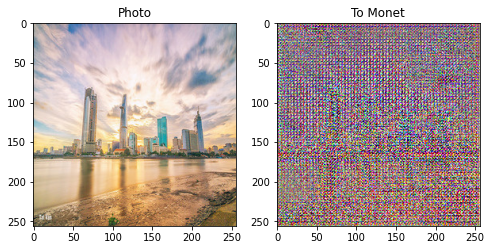

In [51]:
to_monet = generator_a(example_photo)
plt.figure(figsize=(8,8))
contrast = 5

img = [example_photo, to_monet]
title = ["Photo", "To Monet"]

for i in range(len(img)):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(img[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(img[i][0]* 0.5 * contrast + 0.5)
plt.show()

In [52]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [53]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated),generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [54]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [55]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [56]:
generator_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_b_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_b_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [57]:
checkpoint_path = "checkpoints/train"

ckpt = tf.train.Checkpoint(generator_a=generator_a,
                           generator_b=generator_b,
                           discriminator_a=discriminator_a,
                           discriminator_b=discriminator_b,
                           generator_a_optimizer=generator_a_optimizer,
                           generator_b_optimizer=generator_b_optimizer,
                           discriminator_a_optimizer=discriminator_a_optimizer,
                           discriminator_b_optimizer=discriminator_b_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [58]:
epochs = 10

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [59]:
@tf.function
def train_step(real_a, real_b):
  with tf.GradientTape(persistent=True) as tape:


    fake_b = generator_a(real_a, training=True)
    cycled_a = generator_b(fake_b, training=True)

    fake_a = generator_b(real_b, training=True)
    cycled_b = generator_a(fake_a, training=True)

    same_a = generator_b(real_a, training=True)
    same_b = generator_a(real_b, training=True)

    disc_real_a = discriminator_a(real_a, training=True)
    disc_real_b = discriminator_b(real_b, training=True)

    disc_fake_a = discriminator_a(fake_a, training=True)
    disc_fake_b = discriminator_b(fake_b, training=True)

    # calculate the loss
    gen_a_loss = generator_loss(disc_fake_b)
    gen_b_loss = generator_loss(disc_fake_a)

    total_cycle_loss = calc_cycle_loss(real_a, cycled_a) + calc_cycle_loss(real_b, cycled_b)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_a_loss = gen_a_loss + total_cycle_loss + identity_loss(real_b, same_b)
    total_gen_b_loss = gen_b_loss + total_cycle_loss + identity_loss(real_a, same_a)

    disc_a_loss = discriminator_loss(disc_real_a, disc_fake_a)
    disc_b_loss = discriminator_loss(disc_real_b, disc_fake_b)

  # Calculate the gradients for generator and discriminator
  generator_a_gradients = tape.gradient(total_gen_a_loss, 
                                        generator_a.trainable_variables)
  generator_b_gradients = tape.gradient(total_gen_b_loss, 
                                        generator_b.trainable_variables)

  discriminator_a_gradients = tape.gradient(disc_a_loss, 
                                            discriminator_a.trainable_variables)
  discriminator_b_gradients = tape.gradient(disc_b_loss, 
                                            discriminator_b.trainable_variables)

  # Apply the gradients to the optimizer
  generator_a_optimizer.apply_gradients(zip(generator_a_gradients, 
                                            generator_a.trainable_variables))

  generator_b_optimizer.apply_gradients(zip(generator_b_gradients, 
                                            generator_b.trainable_variables))

  discriminator_a_optimizer.apply_gradients(zip(discriminator_a_gradients,
                                                discriminator_a.trainable_variables))

  discriminator_b_optimizer.apply_gradients(zip(discriminator_b_gradients,
                                                discriminator_b.trainable_variables))

In [61]:
!pip install IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00


In [63]:
from IPython.display import clear_output

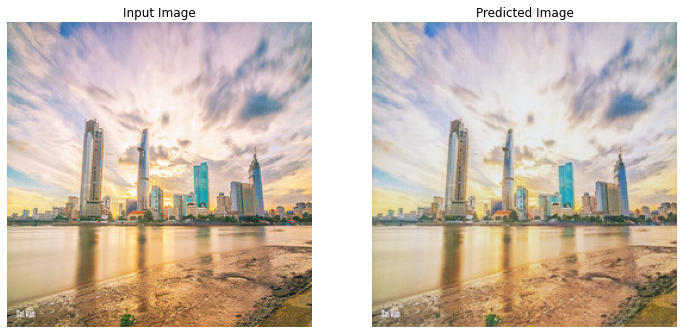

Saving checpoint for epoch 10 at checkpoints/train/ckpt-4


In [70]:
for e in range(epochs):
  n = 0
  for image_a, image_b in tf.data.Dataset.zip((photo_data, monet_data)):
    train_step(image_a, image_b)
    if n% 10 == 0:
      print(".", end="")
    n +=1
  clear_output(wait = True)

  generate_images(generator_a, example_photo)
  if (e + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f"Saving checpoint for epoch {e +1} at {ckpt_save_path}")




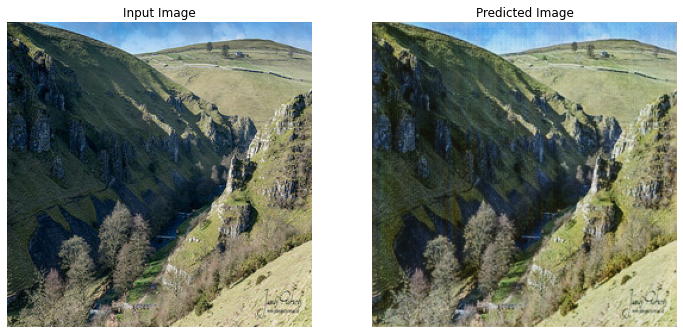

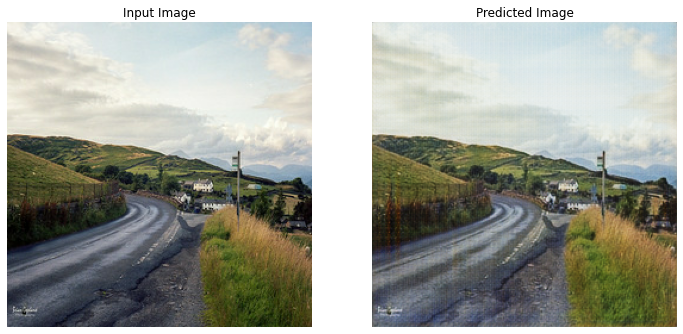

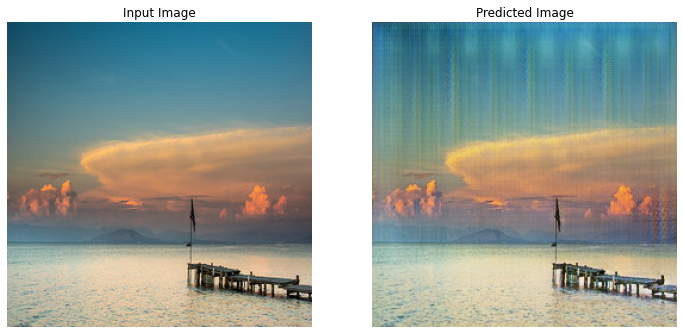

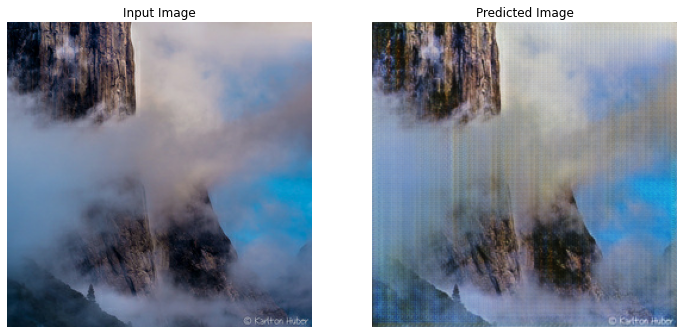

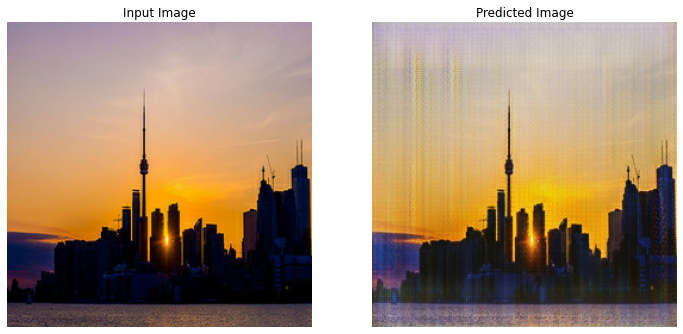

In [71]:
for input in photo_data.take(5):
  generate_images(generator_a, input)